# VANET Attack Detection and Mitigation Analysis

This notebook analyzes the output from the VANET simulation that includes DDoS, Sybil, Replay, Jamming, and Message Falsification attacks with various mitigation techniques.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Load All Datasets

In [2]:
# Load all generated CSV files
bsm_df = pd.read_csv('csv/bsm_log.csv')
attack_df = pd.read_csv('csv/attack_log.csv')
mitigation_df = pd.read_csv('csv/mitigation_log.csv')
trust_df = pd.read_csv('csv/trust_log.csv')
ml_detection_df = pd.read_csv('csv/ml_detection_log.csv')
neighbor_df = pd.read_csv('csv/neighbor_log.csv')
jammer_df = pd.read_csv('csv/jammer_log.csv')
sybil_df = pd.read_csv('csv/sybil_log.csv')
ddos_df = pd.read_csv('csv/ddos_log.csv')
msg_falsification_df = pd.read_csv('csv/msg_falsification_log.csv')
features_df = pd.read_csv('csv/features_log.csv')
detection_df = pd.read_csv('csv/detection_log.csv')

print("Dataset shapes:")
print(f"BSM Log: {bsm_df.shape}")
print(f"Attack Log: {attack_df.shape}")
print(f"Mitigation Log: {mitigation_df.shape}")
print(f"Trust Log: {trust_df.shape}")
print(f"ML Detection Log: {ml_detection_df.shape}")
print(f"Neighbor Log: {neighbor_df.shape}")
print(f"Jammer Log: {jammer_df.shape}")
print(f"Sybil Log: {sybil_df.shape}")
print(f"DDoS Log: {ddos_df.shape}")
print(f"Message Falsification Log: {msg_falsification_df.shape}")
print(f"Features Log: {features_df.shape}")
print(f"Detection Log: {detection_df.shape}")

Dataset shapes:
BSM Log: (11880, 6)
Attack Log: (0, 4)
Mitigation Log: (89, 4)
Trust Log: (1188, 4)
ML Detection Log: (0, 4)
Neighbor Log: (5940, 4)
Jammer Log: (8000, 3)
Sybil Log: (451, 5)
DDoS Log: (902, 4)
Message Falsification Log: (91, 4)
Features Log: (132, 8)
Detection Log: (0, 4)


## 1. Basic Dataset Overview

In [3]:
# Display basic info about BSM data
print("BSM Data Overview:")
print(bsm_df.head())
print(f"\nData types:\n{bsm_df.dtypes}")
print(f"\nBasic statistics:\n{bsm_df.describe()}")

BSM Data Overview:
   nodeId     posX     posY  velX  velY  timestamp
0       0  2284.39  1085.59     0     0        1.0
1       1  3048.06  1482.58     0     0        1.0
2       2  2443.37  1653.58     0     0        1.0
3       3  2347.21  1889.27     0     0        1.0
4       4  1056.29   795.06     0     0        1.0

Data types:
nodeId         int64
posX         float64
posY         float64
velX           int64
velY           int64
timestamp    float64
dtype: object

Basic statistics:
             nodeId          posX          posY     velX     velY  \
count  11880.000000  11880.000000  11880.000000  11880.0  11880.0   
mean      65.500000   1735.480227   1284.535682      0.0      0.0   
std       38.105628    825.688805    698.128720      0.0      0.0   
min        0.000000    122.620000     17.200000      0.0      0.0   
25%       32.750000   1012.015000    648.485000      0.0      0.0   
50%       65.500000   1859.490000   1305.705000      0.0      0.0   
75%       98.250000 

In [4]:
# Display feature data
print("Features Data Overview:")
print(features_df.head())
print(f"\nData types:\n{features_df.dtypes}")
print(f"\nBasic statistics:\n{features_df.describe()}")

Features Data Overview:
   nodeId     posX     posY  speed  heading  timestamp  interArrivalTime  \
0       0  2284.39  1085.59      0        0          1                 0   
1       1  3048.06  1482.58      0        0          1                 0   
2       2  2443.37  1653.58      0        0          1                 0   
3       3  2347.21  1889.27      0        0          1                 0   
4       4  1056.29   795.06      0        0          1                 0   

   avgPayloadSize  
0             200  
1             200  
2             200  
3             200  
4             200  

Data types:
nodeId                int64
posX                float64
posY                float64
speed                 int64
heading               int64
timestamp             int64
interArrivalTime      int64
avgPayloadSize        int64
dtype: object

Basic statistics:
           nodeId         posX         posY  speed  heading  timestamp  \
count  132.000000   132.000000   132.000000  132.0    1

## 2. Visualization of VANET Behaviors

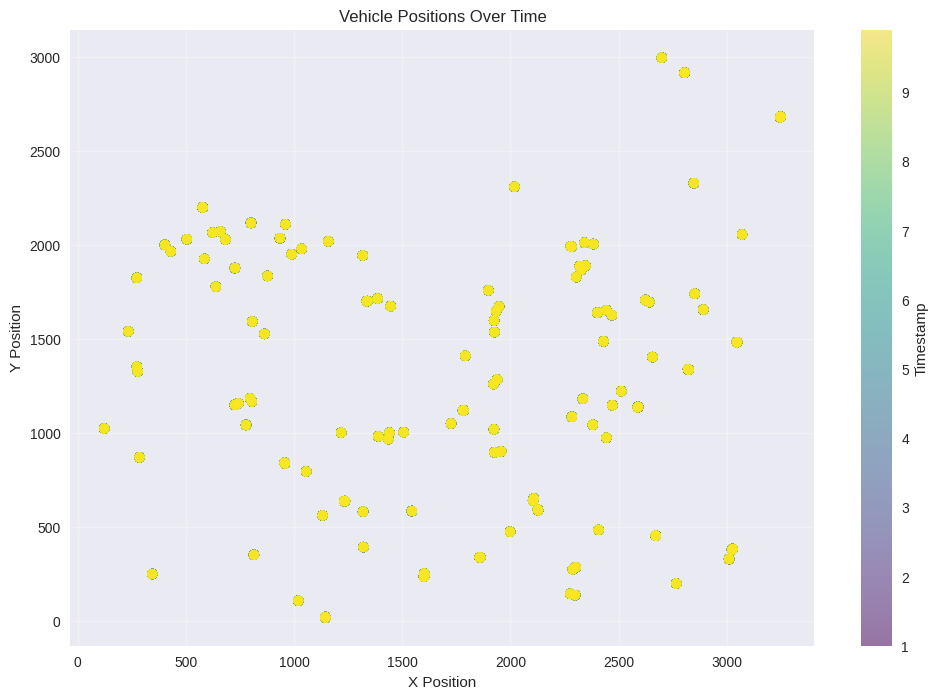

In [5]:
# Plot vehicle positions over time
plt.figure(figsize=(12, 8))
plt.scatter(bsm_df['posX'], bsm_df['posY'], alpha=0.5, c=bsm_df['timestamp'], cmap='viridis')
plt.colorbar(label='Timestamp')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Vehicle Positions Over Time')
plt.grid(True, alpha=0.3)
plt.show()

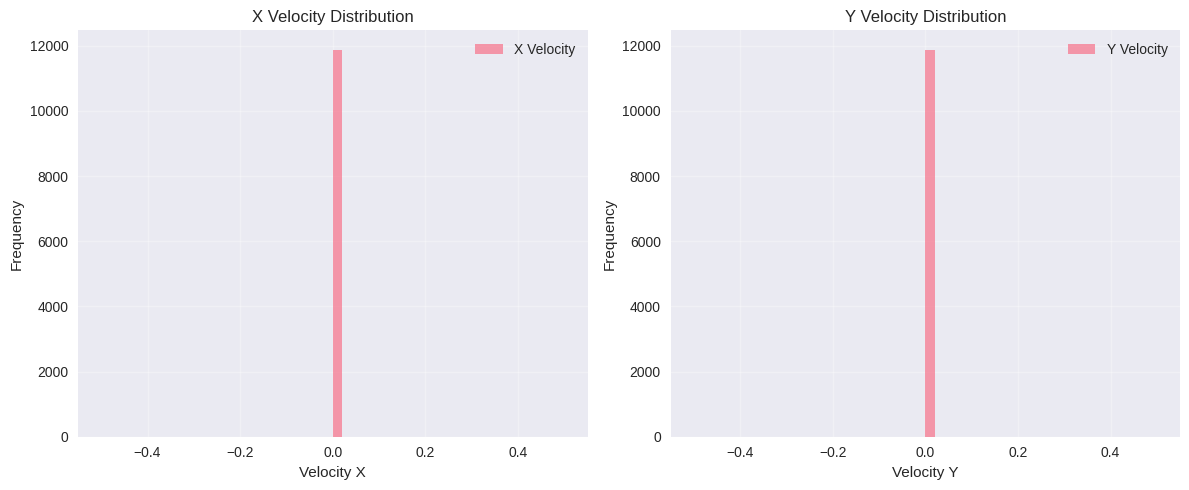

In [6]:
# Plot velocity distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(bsm_df['velX'], bins=50, alpha=0.7, label='X Velocity')
plt.xlabel('Velocity X')
plt.ylabel('Frequency')
plt.title('X Velocity Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(bsm_df['velY'], bins=50, alpha=0.7, label='Y Velocity')
plt.xlabel('Velocity Y')
plt.ylabel('Frequency')
plt.title('Y Velocity Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Attack Analysis

In [7]:
# Analyze DDoS attacks
print("DDoS Attack Details:")
print(f"Total DDoS attack records: {len(ddos_df)}")
print(f"DDoS attackers: {ddos_df['attackerId'].unique()}")
print(f"Attack details sample:\n{ddos_df.head(10)}")

DDoS Attack Details:
Total DDoS attack records: 902
DDoS attackers: [5]
Attack details sample:
   timestamp  attackerId   attackType detail
0        1.0           5  ddos_attack      0
1        1.0           5  ddos_attack      1
2        1.0           5  ddos_attack      2
3        1.0           5  ddos_attack      3
4        1.0           5  ddos_attack      4
5        1.0           5  ddos_attack      5
6        1.0           5  ddos_attack      6
7        1.0           5  ddos_attack      7
8        1.0           5  ddos_attack      8
9        1.0           5  ddos_attack      9


In [8]:
# Analyze Sybil attacks
print("Sybil Attack Details:")
print(f"Total Sybil attack records: {len(sybil_df)}")
print(f"Sybil attackers: {sybil_df['attackerId'].unique()}")
print(f"Fake IDs count: {len(sybil_df['fakeId'].unique())}")
print(f"Sybil attack sample:\n{sybil_df.head(10)}")

Sybil Attack Details:
Total Sybil attack records: 451
Sybil attackers: ['10' 'attack_started']
Fake IDs count: 6
Sybil attack sample:
   timestamp  fakeId attackerId     posX   posY
0        1.0   10001         10  1154.14  31.18
1        1.0   10002         10  1164.14  41.18
2        1.0   10003         10  1174.14  51.18
3        1.0   10004         10  1184.14  61.18
4        1.0   10005         10  1194.14  71.18
5        1.1   10001         10  1154.14  31.18
6        1.1   10002         10  1164.14  41.18
7        1.1   10003         10  1174.14  51.18
8        1.1   10004         10  1184.14  61.18
9        1.1   10005         10  1194.14  71.18


In [9]:
# Analyze Jamming attacks
print("Jamming Attack Details:")
print(f"Total Jamming records: {len(jammer_df)}")
print(f"Jammer IDs: {jammer_df['jammerId'].unique()}")
print(f"Jamming attack sample:\n{jammer_df.head(10)}")

Jamming Attack Details:
Total Jamming records: 8000
Jammer IDs: [25]
Jamming attack sample:
   timestamp  jammerId       eventType
0      2.000        25  jamming_active
1      2.001        25  jamming_active
2      2.002        25  jamming_active
3      2.003        25  jamming_active
4      2.004        25  jamming_active
5      2.005        25  jamming_active
6      2.006        25  jamming_active
7      2.007        25  jamming_active
8      2.008        25  jamming_active
9      2.009        25  jamming_active


In [10]:
# Analyze Message Falsification attacks
print("Message Falsification Details:")
print(f"Total Falsification records: {len(msg_falsification_df)}")
print(f"Falsifier IDs: {msg_falsification_df['attackerId'].unique()}")
print(f"Falsification attack sample:\n{msg_falsification_df.head(10)}")

Message Falsification Details:
Total Falsification records: 91
Falsifier IDs: [20]
Falsification attack sample:
   timestamp  attackerId fakePosX fakePosY
0        1.0          20  3546.62  1982.59
1        1.1          20  3546.62  1982.59
2        1.2          20  3546.62  1982.59
3        1.3          20  3546.62  1982.59
4        1.4          20  3546.62  1982.59
5        1.5          20  3546.62  1982.59
6        1.6          20  3546.62  1982.59
7        1.7          20  3546.62  1982.59
8        1.8          20  3546.62  1982.59
9        1.9          20  3546.62  1982.59


## 4. Trust System Analysis

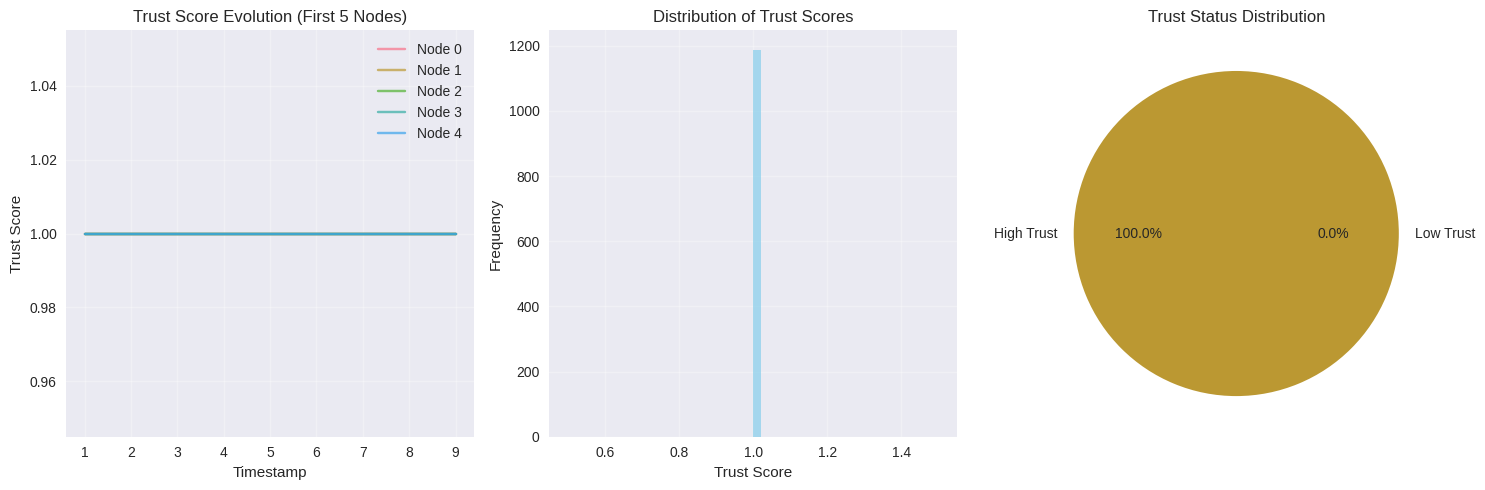

Nodes with low trust: 0
Nodes with high trust: 132


In [11]:
# Trust score evolution over time
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for node_id in trust_df['nodeId'].unique()[:5]:  # Plot first 5 nodes
    node_data = trust_df[trust_df['nodeId'] == node_id]
    plt.plot(node_data['timestamp'], node_data['trustScore'], label=f'Node {node_id}', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Trust Score')
plt.title('Trust Score Evolution (First 5 Nodes)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(trust_df['trustScore'], bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Trust Score')
plt.ylabel('Frequency')
plt.title('Distribution of Trust Scores')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
low_trust_nodes = trust_df[trust_df['lowTrustFlag'] == 1]['nodeId'].nunique()
high_trust_nodes = trust_df[trust_df['lowTrustFlag'] == 0]['nodeId'].nunique()
plt.pie([low_trust_nodes, high_trust_nodes], labels=['Low Trust', 'High Trust'], autopct='%1.1f%%')
plt.title('Trust Status Distribution')

plt.tight_layout()
plt.show()

print(f"Nodes with low trust: {low_trust_nodes}")
print(f"Nodes with high trust: {high_trust_nodes}")

## 5. ML Features Analysis

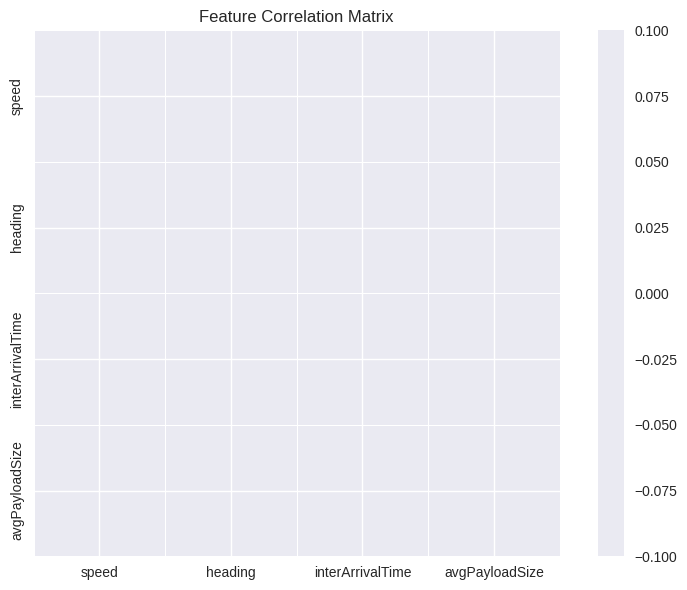

In [12]:
# Feature correlation matrix
feature_cols = ['speed', 'heading', 'interArrivalTime', 'avgPayloadSize']
features_subset = features_df[feature_cols].copy()

# Drop rows with NaN or infinite values
features_subset = features_subset.replace([np.inf, -np.inf], np.nan).dropna()

if not features_subset.empty:
    correlation_matrix = features_subset.corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

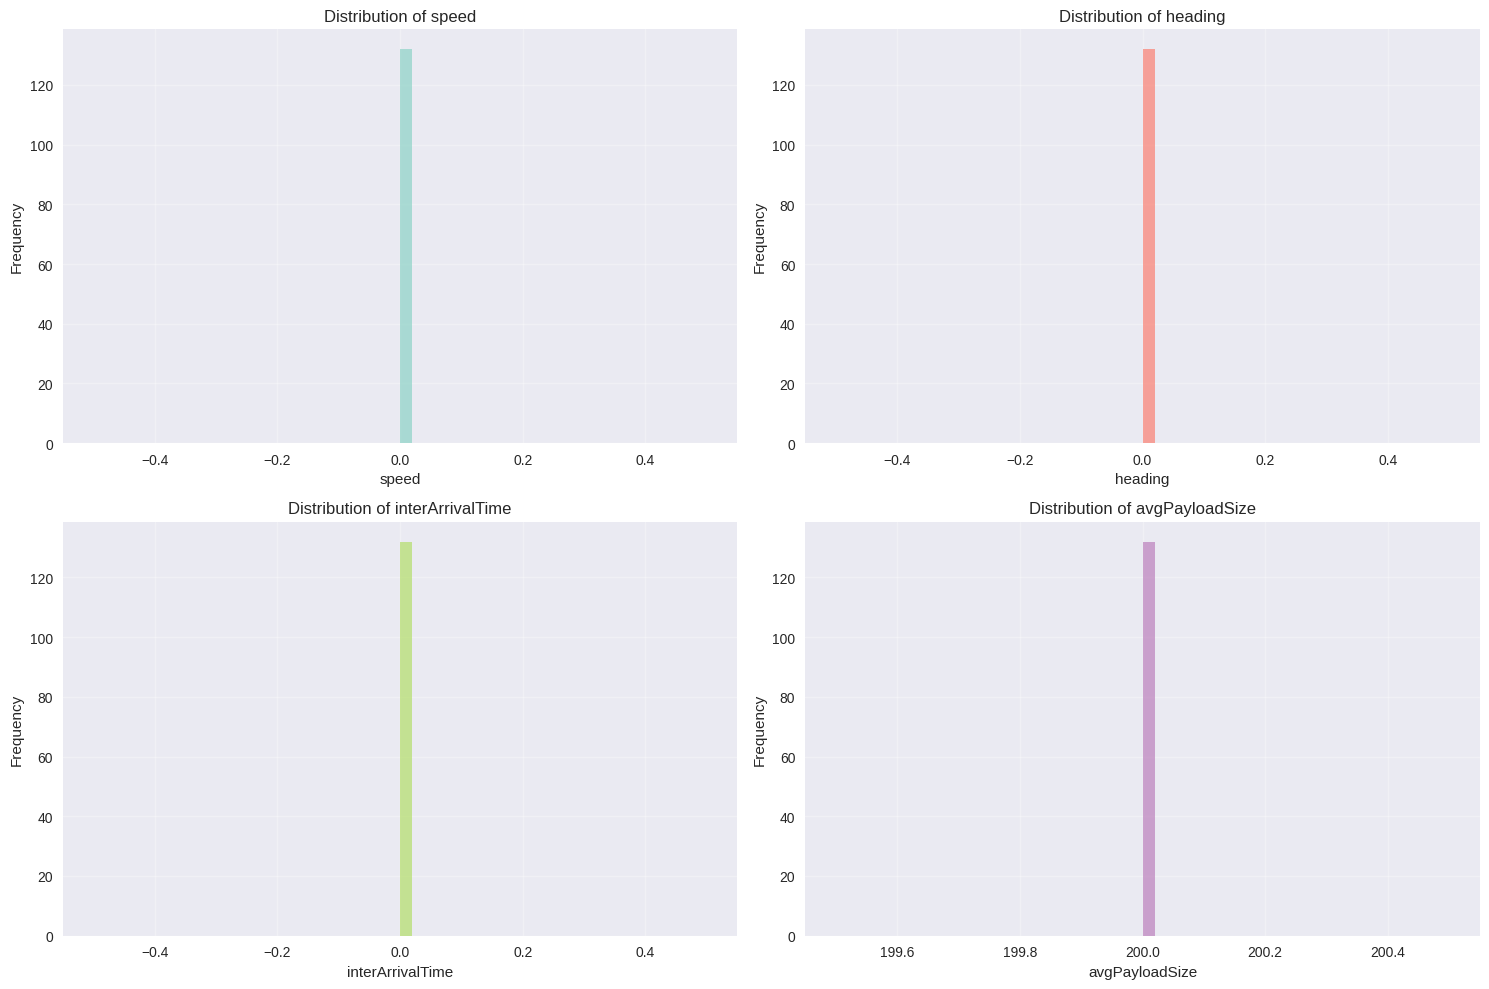

In [13]:
# Feature distributions
plt.figure(figsize=(15, 10))

for i, col in enumerate(feature_cols):
    plt.subplot(2, 2, i+1)
    plt.hist(features_df[col].dropna(), bins=50, alpha=0.7, color=plt.cm.Set3(i/len(feature_cols)))
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Neighbor Analysis

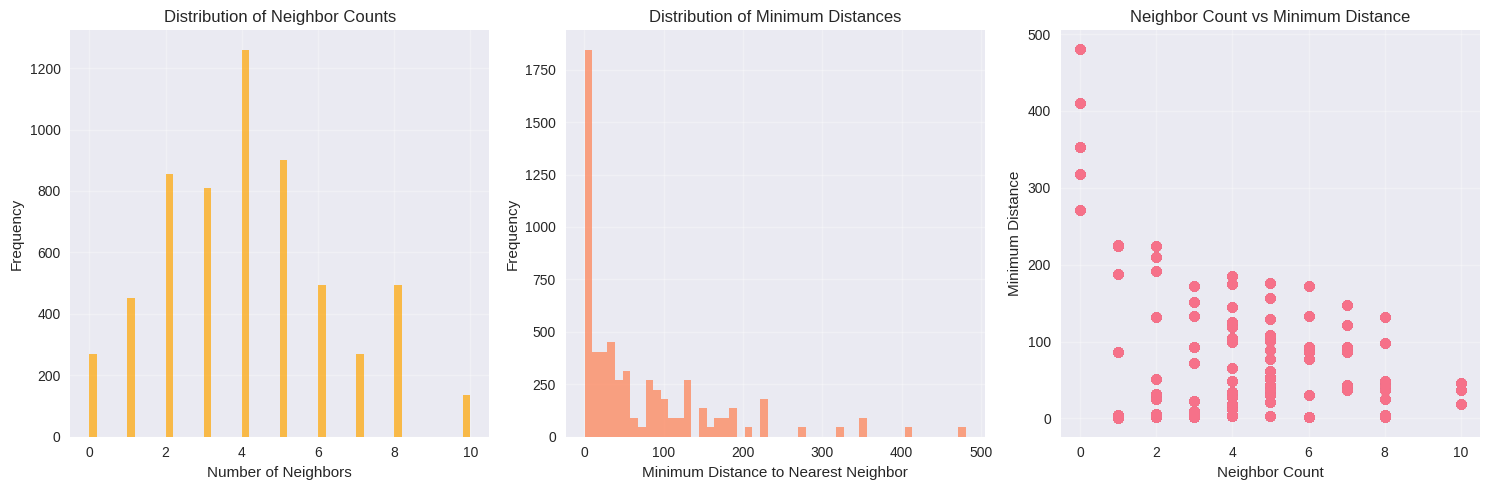

Average neighbor count: 4.09
Average minimum distance: 71.37


In [14]:
# Neighbor count and distance analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(neighbor_df['neighborCount'], bins=50, alpha=0.7, color='orange')
plt.xlabel('Number of Neighbors')
plt.ylabel('Frequency')
plt.title('Distribution of Neighbor Counts')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(neighbor_df['minDistance'], bins=50, alpha=0.7, color='coral')
plt.xlabel('Minimum Distance to Nearest Neighbor')
plt.ylabel('Frequency')
plt.title('Distribution of Minimum Distances')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(neighbor_df['neighborCount'], neighbor_df['minDistance'], alpha=0.5)
plt.xlabel('Neighbor Count')
plt.ylabel('Minimum Distance')
plt.title('Neighbor Count vs Minimum Distance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average neighbor count: {neighbor_df['neighborCount'].mean():.2f}")
print(f"Average minimum distance: {neighbor_df['minDistance'].mean():.2f}")

## 7. ML Model Development

In [15]:
# Prepare data for ML
# Create a labeled dataset by merging with attack data

# Create a label column based on attack logs
features_labeled = features_df.copy()
features_labeled['is_attacker'] = 0  # Initialize as non-attacker

# Mark nodes that appear in attack logs as attackers
attack_nodes = set()
if not ddos_df.empty:
    attack_nodes.update(ddos_df['attackerId'].unique())
if not sybil_df.empty:
    attack_nodes.update(sybil_df['attackerId'].unique())
if not msg_falsification_df.empty:
    attack_nodes.update(msg_falsification_df['attackerId'].unique())

# Mark nodes as attackers
features_labeled.loc[features_labeled['nodeId'].isin(attack_nodes), 'is_attacker'] = 1

# Prepare features for ML model
feature_cols_for_ml = ['speed', 'heading', 'interArrivalTime', 'avgPayloadSize']
X = features_labeled[feature_cols_for_ml].copy()
y = features_labeled['is_attacker'].copy()

# Handle infinite values and NaN
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

print(f"Feature matrix shape: {X.shape}")
print(f"Label distribution - Normal: {(y == 0).sum()}, Attackers: {(y == 1).sum()}")

Feature matrix shape: (132, 4)
Label distribution - Normal: 130, Attackers: 2


In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

try:
    auc_score = roc_auc_score(y_test, y_pred_proba_rf)
    print(f"AUC Score: {auc_score:.3f}")
except ValueError:
    print("AUC Score: Cannot compute (only one class present)")

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

AUC Score: nan


In [17]:
# Train a Gradient Boosting classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Gradient Boosting Results:")
print(classification_report(y_test, y_pred_gb))

try:
    auc_score = roc_auc_score(y_test, y_pred_proba_gb)
    print(f"AUC Score: {auc_score:.3f}")
except ValueError:
    print("AUC Score: Cannot compute (only one class present)")

Gradient Boosting Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

AUC Score: nan


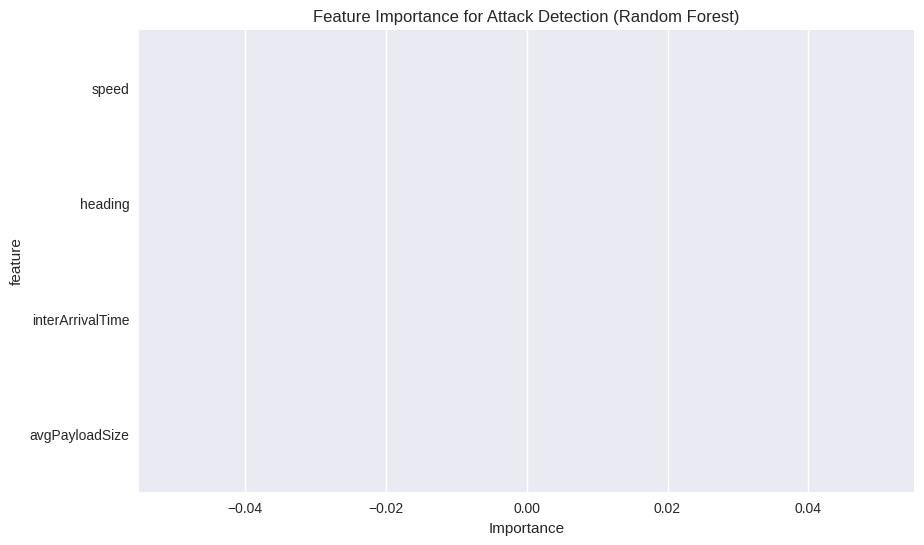

Feature Importance:
            feature  importance
0             speed         0.0
1           heading         0.0
2  interArrivalTime         0.0
3    avgPayloadSize         0.0


In [18]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_cols_for_ml,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Attack Detection (Random Forest)')
plt.xlabel('Importance')
plt.show()

print("Feature Importance:")
print(feature_importance)

## 8. Cross-Validation for Model Performance

In [19]:
# Perform cross-validation
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='f1')
gb_scores = cross_val_score(gb_model, X, y, cv=5, scoring='f1')

print(f"Random Forest CV F1 Scores: {rf_scores}")
print(f"Random Forest CV F1 Mean: {rf_scores.mean():.3f} (+/- {rf_scores.std() * 2:.3f})")

print(f"\nGradient Boosting CV F1 Scores: {gb_scores}")
print(f"Gradient Boosting CV F1 Mean: {gb_scores.mean():.3f} (+/- {gb_scores.std() * 2:.3f})")

Random Forest CV F1 Scores: [0. 0. 0. 0. 0.]
Random Forest CV F1 Mean: 0.000 (+/- 0.000)

Gradient Boosting CV F1 Scores: [0. 0. 0. 0. 0.]
Gradient Boosting CV F1 Mean: 0.000 (+/- 0.000)


## 9. Detection Performance Analysis

In [20]:
# Analyze detection results if available
if not detection_df.empty:
    print("Detection Results Analysis:")
    print(f"Total detection records: {len(detection_df)}")
    print(f"Detection types: {detection_df['attackType'].unique()}")
    print(f"Average detection score: {detection_df['detectionScore'].mean():.3f}")
    
    # Plot detection scores
    plt.figure(figsize=(10, 6))
    for attack_type in detection_df['attackType'].unique():
        attack_data = detection_df[detection_df['attackType'] == attack_type]
        if not attack_data.empty:
            plt.hist(attack_data['detectionScore'], alpha=0.6, label=attack_type, bins=20)
    
    plt.xlabel('Detection Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Detection Scores by Attack Type')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No detection results available in detection_log.csv")

No detection results available in detection_log.csv


## 10. Summary and Insights

In [21]:
# Generate summary statistics
print("=== VANET SIMULATION SUMMARY ===")
print(f"Total BSM messages: {len(bsm_df)}")
print(f"Total vehicles in simulation: {bsm_df['nodeId'].nunique()}")
print(f"Simulation duration: {bsm_df['timestamp'].max() - bsm_df['timestamp'].min():.2f} seconds")

print(f"\nAttacks detected:")
if not ddos_df.empty:
    print(f"  - DDoS attacks: {ddos_df['attackerId'].nunique()} malicious nodes")
if not sybil_df.empty:
    print(f"  - Sybil attacks: {sybil_df['attackerId'].nunique()} malicious nodes")
if not jammer_df.empty:
    print(f"  - Jamming attacks: {jammer_df['jammerId'].nunique()} jammer nodes")
if not msg_falsification_df.empty:
    print(f"  - Message falsification: {msg_falsification_df['attackerId'].nunique()} malicious nodes")

print(f"\nTrust system effectiveness:")
if not trust_df.empty:
    avg_trust = trust_df['trustScore'].mean()
    low_trust_count = trust_df[trust_df['lowTrustFlag'] == 1]['nodeId'].nunique()
    print(f"  - Average trust score: {avg_trust:.3f}")
    print(f"  - Nodes flagged as low trust: {low_trust_count}")

print(f"\nML Model Performance:")
if 'rf_scores' in locals():
    print(f"  - Random Forest F1 Score: {rf_scores.mean():.3f}")
if 'gb_scores' in locals():
    print(f"  - Gradient Boosting F1 Score: {gb_scores.mean():.3f}")

print(f"\n=== END SUMMARY ===")

=== VANET SIMULATION SUMMARY ===
Total BSM messages: 11880
Total vehicles in simulation: 132
Simulation duration: 8.90 seconds

Attacks detected:
  - DDoS attacks: 1 malicious nodes
  - Sybil attacks: 2 malicious nodes
  - Jamming attacks: 1 jammer nodes
  - Message falsification: 1 malicious nodes

Trust system effectiveness:
  - Average trust score: 1.000
  - Nodes flagged as low trust: 0

ML Model Performance:
  - Random Forest F1 Score: 0.000
  - Gradient Boosting F1 Score: 0.000

=== END SUMMARY ===
